In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine


DATA_PATH = "../data/wine.csv"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def load_data(DATA_PATH):
    #df = pd.read_csv(DATA_PATH, sep=',', header=None, names=['Wine','Alcohol','Malic.acid','Ash','Acl','Mg','Phenols','Flavanoids','Nonflavanoid.phenols','Proanth','Color.int','Hue','OD','Proline'])
    df = pd.read_csv(DATA_PATH)
    df = df.fillna(-99) # replace nan with -99
    df_base = df.iloc[:, 1:]
    df_wine = df.iloc[:,0].values# get wine Label
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    standardizer = preprocessing.StandardScaler() # stadardize values
    x = standardizer.fit_transform(x)    
    return x, standardizer, df_wine # 3- Dimensions

In [4]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self,DATA_PATH, train=True):
        self.x, self.standardizer, self.wine = load_data(DATA_PATH)
        if train:
            self.x = torch.from_numpy(self.x)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.x)
            self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [5]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # self.decode(z) ist später recon_batch, mu ist mu und logvar ist logvar
        return self.decode(z), mu, logvar

In [6]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [7]:
data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=1024)

In [8]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = customLoss()#LOSS


In [9]:
# Traning the Model
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)#.to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [10]:
epochs = 15500
log_interval = 50
val_losses = []
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average loss: 13.0982
====> Epoch: 400 Average loss: 9.1792
====> Epoch: 600 Average loss: 8.9058
====> Epoch: 800 Average loss: 8.1939
====> Epoch: 1000 Average loss: 7.8505
====> Epoch: 1200 Average loss: 7.7301
====> Epoch: 1400 Average loss: 7.6486
====> Epoch: 1600 Average loss: 7.4416
====> Epoch: 1800 Average loss: 7.1600
====> Epoch: 2000 Average loss: 7.1746
====> Epoch: 2200 Average loss: 6.8434
====> Epoch: 2400 Average loss: 6.7923
====> Epoch: 2600 Average loss: 6.8142
====> Epoch: 2800 Average loss: 6.6260
====> Epoch: 3000 Average loss: 6.7376
====> Epoch: 3200 Average loss: 6.6228
====> Epoch: 3400 Average loss: 6.5936
====> Epoch: 3600 Average loss: 6.5588
====> Epoch: 3800 Average loss: 6.5468
====> Epoch: 4000 Average loss: 6.4159
====> Epoch: 4200 Average loss: 6.2713
====> Epoch: 4400 Average loss: 6.3426
====> Epoch: 4600 Average loss: 6.5079
====> Epoch: 4800 Average loss: 6.3587
====> Epoch: 5000 Average loss: 6.2729
====> Epoch: 5200 Average lo

In [11]:
# This ensures that the input data is scaled in the same way as the 
# training data, which can improve the performance of the model.
standardizer = trainloader.dataset.standardizer

model.eval()
test_loss = 0
# no_grad() bedeutet wir nehmen die vorher berechneten Gewichte und erneuern sie nicht
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)#.to(torch.float32)
        recon_batch, mu, logvar = model(data)

#standardizer.inverse_transform(recon_batch[65].cpu().numpy())
#standardizer.inverse_transform(data[65].cpu().numpy())

In [12]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

mu_result.shape

torch.Size([178, 3])

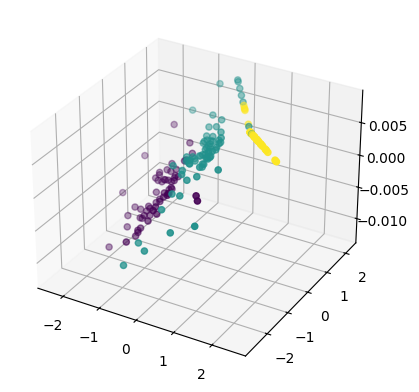

In [13]:
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
winetype = data_set.wine
zdata = mu_result[:,0].cpu().numpy()
xdata = mu_result[:,1].cpu().numpy()
ydata = mu_result[:,2].cpu().numpy()
ax.scatter3D(xdata, ydata, zdata, c=winetype);